### 🔧 Configuration et Imports

Commençons par importer toutes les bibliothèques nécessaires et configurer notre environnement NLP.

In [ ]:
import os
import logging
import sqlite3
import json
import re
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
# Imports principaux pour le NLP
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer, create_optimizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
import kagglehub

warnings.filterwarnings('ignore')

logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
logger = logging.getLogger(__name__)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

### 🖥️ Configuration GPU pour NLP

Les modèles de NLP comme DistilBERT consomment beaucoup de mémoire. Configurons le GPU prudemment :

In [ ]:
# Configuration TensorFlow
tf.config.run_functions_eagerly(True)  # Pour le debugging
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
print(f"🚀 TensorFlow version: {tf.__version__}")
print(f"💻 GPU disponible: {'✅ Oui' if len(gpus) > 0 else '❌ Non (CPU utilisé)'}")

# Configuration GPU spéciale pour les modèles NLP volumineux
if gpus:
    try:
        # Utiliser seulement le premier GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Croissance mémoire progressive (important pour les transformers)
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Configuration GPU réussie: {gpus[0].name}")
        print("🧠 Mémoire GPU configurée en croissance progressive")
    except RuntimeError as e:
        print(f"⚠️ Erreur configuration GPU: {e}")
else:
    print("🔧 Utilisation du CPU - Les modèles NLP fonctionnent aussi (plus lentement)")

print("\n💡 Info: Les modèles de transformers comme DistilBERT utilisent beaucoup de mémoire")
print("   La croissance progressive évite les erreurs 'Out of Memory'")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🚀 TensorFlow version: 2.19.0
💻 GPU disponible: ✅ Oui
✅ Configuration GPU réussie: /physical_device:GPU:0
🧠 Mémoire GPU configurée en croissance progressive

💡 Info: Les modèles de transformers comme BERTweet utilisent beaucoup de mémoire
   La croissance progressive évite les erreurs 'Out of Memory'


### Configuration globale

In [32]:
# 📊 Paramètres spécifiques au fine-tuning NLP
MODEL_NAME = 'distilbert-base-uncased'
BATCH_SIZE = 16            # Taille du batch
MAX_LENGTH = 256           # Longueur max des séquences (tokens)
EPOCHS = 5                 # Nombre d'époques
LEARNING_RATE = 2e-5       # Learning rate typique pour BERT/DistilBERT
NUM_CLASSES = 1            # Binary classification with sigmoid (NEGATIVE/POSITIVE)
DROP_RATE = 0.3            # Taux de dropout
WARMUP_STEPS = 500        # Nombre de pas de warmup

NUM_SAMPLES_TRAIN = 5000   # Limitation pour l'exemple pédagogique
NUM_SAMPLES_VAL = 1000     # Échantillon de validation

print("📋 Configuration d'entraînement NLP:")
print(f"   • Taille de batch: {BATCH_SIZE}")
print(f"   • Longueur max: {MAX_LENGTH} tokens")
print(f"   • Nombre d'époques: {EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Échantillons train/val: {NUM_SAMPLES_TRAIN}/{NUM_SAMPLES_VAL}")


📋 Configuration d'entraînement NLP:
   • Taille de batch: 16
   • Longueur max: 256 tokens
   • Nombre d'époques: 5
   • Learning rate: 2e-05
   • Échantillons train/val: 5000/1000


## 🔤 Tokenisation avec DistilBERT

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=False,     # pour DistilBERT
    normalization=True  # Active la normalisation des tweets
    #use_fast=True,     # pour DistilBERT
)

print(f"✅ Tokenizer {MODEL_NAME} chargé avec succès !")
print(f"📊 Taille du vocabulaire: {tokenizer.vocab_size:,} tokens")

✅ Tokenizer distilbert-base-uncased chargé avec succès !
📊 Taille du vocabulaire: 30,522 tokens


## 🐦 Pipeline de Prétraitement des Données

In [36]:
def load_sqlite_dataset_with_preprocessing(db_path, table_name='sentiment_analysis_training', train_split=0.8):
    # Download latest version
    dataset_path = kagglehub.dataset_download("gautamchettiar/bitcoin-sentiment-analysis-twitter-data")
    print(f"Fichiers téléchargés dans: {dataset_path}")
    print(os.listdir(dataset_path))
    df = pd.read_csv(os.path.join(dataset_path, 'bitcoin_tweets1000000.csv'), encoding='ISO-8859-1')

    # Séparation du DataFrame par sentiment
    df_sentiment_0 = df[df['sentiment'] == 0]
    df_sentiment_1 = df[df['sentiment'] == 1]

    # Vérification des tailles disponibles
    print(f"Nombre d'exemples avec sentiment 0: {len(df_sentiment_0)}")
    print(f"Nombre d'exemples avec sentiment 1: {len(df_sentiment_1)}")

    # Échantillonner 2500 exemples de chaque classe
    sample_size = min(2500, len(df_sentiment_0), len(df_sentiment_1))

    df_sentiment_0_sample = df_sentiment_0.sample(n=sample_size, random_state=42)
    df_sentiment_1_sample = df_sentiment_1.sample(n=sample_size, random_state=42)

    # Combinaison des échantillons
    df_balanced = pd.concat([df_sentiment_0_sample, df_sentiment_1_sample])

    # Mélange des données
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Taille du nouveau DataFrame équilibré: {len(df_balanced)}")
    print(f"Distribution des sentiments: \n{df_balanced['sentiment'].value_counts()}")

    # Vérification que les données sont bien équilibrées
    assert df_balanced['sentiment'].value_counts()[0] == df_balanced['sentiment'].value_counts()[1]

    # Utilisation de train_test_split avec stratify pour maintenir la distribution des labels
    train_df, test_df = train_test_split(
        df_balanced, 
        train_size=train_split,
        random_state=42,
        stratify=df_balanced['sentiment']  # Garantit la même distribution de labels
    )

    # Distribution des sentiments dans les datasets
    print("\nDistribution des sentiments dans le dataset d'entraînement:")
    print(train_df['sentiment'].value_counts(normalize=True))
    
    print("\nDistribution des sentiments dans le dataset de test:")
    print(test_df['sentiment'].value_counts(normalize=True))

    # Tokenisation des textes
    train_encodings = tokenizer(
        train_df['cleanText'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )
    
    test_encodings = tokenizer(
        test_df['cleanText'].tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

    # Création des datasets de base
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask']
        },
        train_df['sentiment'].values
    ))

    # Optimisations pour l'entraînement
    train_dataset = train_dataset.shuffle(buffer_size=1000)  # Mélanger les données
    train_dataset = train_dataset.batch(BATCH_SIZE)          # Créer des batches
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE) # Préchargement parallèle
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': test_encodings['input_ids'],
            'attention_mask': test_encodings['attention_mask']
        },
        test_df['sentiment'].values
    ))

    # Optimisations pour la validation (pas de shuffle)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset

train_dataset, test_dataset = load_sqlite_dataset_with_preprocessing("./data/xenty.db")

train_texts = []
train_labels = []

for text, label in train_dataset.take(NUM_SAMPLES_TRAIN):
    train_texts.append(text)
    train_labels.append(label.numpy())

test_texts = []
test_labels = []

for text, label in test_dataset.take(NUM_SAMPLES_VAL):
    test_texts.append(text)
    test_labels.append(label.numpy())


Fichiers téléchargés dans: /Users/cedric/.cache/kagglehub/datasets/gautamchettiar/bitcoin-sentiment-analysis-twitter-data/versions/1
['bitcoin_tweets1000000.csv']
Nombre d'exemples avec sentiment 0: 527050
Nombre d'exemples avec sentiment 1: 472936
Taille du nouveau DataFrame équilibré: 5000
Distribution des sentiments: 
sentiment
0.0    2500
1.0    2500
Name: count, dtype: int64

Distribution des sentiments dans le dataset d'entraînement:
sentiment
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64

Distribution des sentiments dans le dataset de test:
sentiment
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## 🧠 Construction du Modèle avec DistilBERT

In [ ]:
# 🧠 Chargement du modèle DistilBERT pré-entraîné
print("🧠 Chargement de DistilBERT pré-entraîné...")
print("(Cela peut prendre quelques minutes la première fois)\n")

# Chargement depuis Hugging Face
distilbert_model = TFAutoModel.from_pretrained(
    MODEL_NAME,
    return_dict=True,           # Retour sous forme de dictionnaire au lieu de tuple
    #output_hidden_states=True,  # Retourne les états cachés
    #from_pt=True,               # Charge les poids depuis PyTorch
)

print("✅ DistilBERT chargé avec succès !")
print(f"📊 Nombre de paramètres: {distilbert_model.num_parameters():,}")
print(f"🔤 Vocabulaire: {tokenizer.vocab_size:,} tokens")

distilbert_model.summary()

🧠 Chargement de BERTweet pré-entraîné...
(Cela peut prendre quelques minutes la première fois)



TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was tr

✅ BERTweet chargé avec succès !
📊 Nombre de paramètres: 66,362,880
🔤 Vocabulaire: 30,522 tokens
Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 1. Figer le modèle DistilBERT complet
distilbert_model.trainable = False
distilbert_model.summary()

In [ ]:
# 🏗️ Fonction de création du modèle complet
def create_sentiment_model(distilbert_model, dropout_rate=DROP_RATE):
    """
    Crée un modèle de classification de sentiment basé sur DistilBERT
    
    Architecture :
    1. DistilBERT pré-entraîné (couche de base)
    2. Extraction du token [CLS] (représentation globale)
    3. Dropout pour régularisation
    4. Dense layer pour classification binaire
    
    Args:
        distilbert_model: Modèle DistilBERT pré-entraîné
        dropout_rate: Taux de dropout (défaut: 0.3)
    
    Returns:
        model: Modèle Keras complet
        base_model: Modèle DistilBERT (pour le fine-tuning)
    """
    print("🏗️ Construction de l'architecture complète...")
    
    # Couches d'entrée
    input_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        dtype=tf.int32, 
        name='input_ids'
    )
    attention_mask = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        dtype=tf.int32, 
        name='attention_mask'
    )
    
    print("   ✅ Couches d'entrée créées")
    
    # DistilBERT pré-entraîné
    DistilBERT_output = distilbert_model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    
    # Extraction des embeddings de séquence
    sequence_output = DistilBERT_output.last_hidden_state  # Shape: (batch_size, seq_len, 768)
    print("   ✅ DistilBERT intégré")
    
    # Pooling : extraction du token [CLS] (première position)
    cls_token = sequence_output[:, 0, :]  # Shape: (batch_size, 768)
    print("   ✅ Token [CLS] extrait")
    
    # Couche de dropout pour la régularisation
    dropout_output = tf.keras.layers.Dropout(dropout_rate, name='dropout')(cls_token)
    print(f"   ✅ Dropout ajouté (rate={dropout_rate})")
    
    # Couche de classification finale
    predictions = tf.keras.layers.Dense(
        NUM_CLASSES, 
        activation='sigmoid',  # Sigmoid pour classification binaire
        name='sentiment_classifier'
    )(dropout_output)
    print("   ✅ Couche de classification ajoutée")
    
    # Création du modèle final
    model = tf.keras.Model(
        inputs=[input_ids, attention_mask],
        outputs=predictions,
        name='DistilBERT_Sentiment_Classifier'
    )
    
    print("\n✅ Modèle construit avec succès !")
    
    return model, distilbert_model

# Construction du modèle
model, base_model = create_sentiment_model(distilbert_model)

# Informations sur le modèle
total_params = sum(tf.size(var).numpy() for var in model.trainable_variables)
print(f"\n📊 Statistiques du modèle:")
print(f"   🔢 Paramètres totaux: {total_params:,}")
print(f"   🎯 Type de classification: Binaire (sentiment)")
print(f"   📏 Longueur d'entrée: {MAX_LENGTH} tokens")
print(f"   🎲 Dropout: {DROP_RATE} ({DROP_RATE * 100}% des neurones désactivés)")

🏗️ Construction de l'architecture complète...
   ✅ Couches d'entrée créées
   ✅ BERTweet intégré
   ✅ Token [CLS] extrait
   ✅ Dropout ajouté (rate=0.3)
   ✅ Couche de classification ajoutée

✅ Modèle construit avec succès !
Couche: input_ids, Entraînable: True
Couche: attention_mask, Entraînable: True
Couche: tf_distil_bert_model, Entraînable: True
Couche: tf.__operators__.getitem, Entraînable: True
Couche: dropout, Entraînable: True
Couche: sentiment_classifier, Entraînable: True
Model: "BERTweet_Sentiment_Classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []        

### 🔧 Test du Modèle

In [23]:
# 🔧 Test du modèle avant entraînement
def tester_modele_avant_entrainement(model, test_dataset):
    """
    Teste que le modèle fonctionne correctement avant l'entraînement
    """
    print("🔧 Test du modèle avant entraînement...\n")
    
    # Prendre un petit batch pour le test
    for batch_features, batch_labels in test_dataset.take(1):
        print(f"📦 Batch de test:")
        print(f"   📏 Taille: {len(batch_labels)} exemples")
        print(f"   📊 Input IDs shape: {batch_features['input_ids'].shape}")
        print(f"   👁️ Attention mask shape: {batch_features['attention_mask'].shape}")
        print(f"   🏷️ Labels shape: {batch_labels.shape}")
        
        # Forward pass (prédiction)
        print(f"\n🔮 Test de prédiction...")
        predictions = model([
            batch_features['input_ids'],
            batch_features['attention_mask']
        ], training=False)
        
        print(f"✅ Prédictions générées !")
        print(f"   📊 Shape des prédictions: {predictions.shape}")
        print(f"   📈 Valeurs min/max: {tf.reduce_min(predictions):.4f} / {tf.reduce_max(predictions):.4f}")
        print(f"   🎯 Moyenne: {tf.reduce_mean(predictions):.4f}")
        
        # Analyse des premières prédictions
        print(f"\n📝 Premières prédictions (avant entraînement):")
        for i in range(min(5, len(predictions))):
            pred_prob = predictions[i].numpy()[0]
            true_label = batch_labels[i].numpy()
            pred_sentiment = "Positif" if pred_prob > 0.5 else "Négatif"
            true_sentiment = "Positif" if true_label == 1 else "Négatif"
            
            print(f"   Exemple {i+1}: Prédit={pred_sentiment} ({pred_prob:.3f}), Vrai={true_sentiment}")
        
        break
    
    print(f"\n💡 Observations:")
    print(f"   🎲 Prédictions aléatoires (modèle non entraîné)")
    print(f"   📊 Valeurs entre 0 et 1 (sigmoid fonctionne)")
    print(f"   ✅ Architecture compatible avec nos données")
    print(f"   🚀 Prêt pour l'entraînement !")

# Tester le modèle
tester_modele_avant_entrainement(model, test_dataset)

🔧 Test du modèle avant entraînement...

📦 Batch de test:
   📏 Taille: 16 exemples
   📊 Input IDs shape: (16, 256)
   👁️ Attention mask shape: (16, 256)
   🏷️ Labels shape: (16,)

🔮 Test de prédiction...
✅ Prédictions générées !
   📊 Shape des prédictions: (16, 1)
   📈 Valeurs min/max: 0.7116 / 0.8013
   🎯 Moyenne: 0.7533

📝 Premières prédictions (avant entraînement):
   Exemple 1: Prédit=Positif (0.788), Vrai=Négatif
   Exemple 2: Prédit=Positif (0.717), Vrai=Positif
   Exemple 3: Prédit=Positif (0.800), Vrai=Négatif
   Exemple 4: Prédit=Positif (0.760), Vrai=Positif
   Exemple 5: Prédit=Positif (0.753), Vrai=Positif

💡 Observations:
   🎲 Prédictions aléatoires (modèle non entraîné)
   📊 Valeurs entre 0 et 1 (sigmoid fonctionne)
   ✅ Architecture compatible avec nos données
   🚀 Prêt pour l'entraînement !


## ⚙️ Compilation du Modèle

Maintenant que notre architecture est construite, configurons l'entraînement :

### 🎯 Configuration des Hyperparamètres

Pour le fine-tuning de DistilBERT, nous utiliserons :

- **Loss Function** : `BinaryCrossentropy` (classification binaire)
- **Optimiseur** : `Adam` avec learning rate adaptatif
- **Métriques** : `Accuracy` et `Precision/Recall`
- **Learning Rate** : Plus faible pour préserver les poids pré-entraînés

In [ ]:
# ⚙️ Configuration de l'optimiseur et des métriques
print("⚙️ Configuration de l'entraînement...\n")

# Optimiseur Adam avec learning rate adapté au fine-tuning
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,  # 2e-5 - plus faible pour préserver les poids
    epsilon=1e-08,               # Stabilité numérique
    clipnorm=1.0                 # Gradient clipping
)

print(f"🎯 Optimiseur configuré:")
print(f"   📊 Type: Adam")
print(f"   📈 Learning rate: {LEARNING_RATE}")
print(f"   ✂️ Gradient clipping: 1.0")
print(f"   🎯 Epsilon: 1e-08")

# Loss function pour classification binaire
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

print(f"\n📉 Loss function:")
print(f"   🎯 Type: Binary Crossentropy")
print(f"   📊 From logits: False (on utilise sigmoid)")

# Métriques de suivi
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

print(f"\n📊 Métriques de suivi:")
for metric in metrics:
    print(f"   • {metric.name}")

print(f"\n💡 Pourquoi ces choix ?")
print(f"   📈 Learning rate faible: Préserver les connaissances pré-entraînées")
print(f"   ✂️ Gradient clipping: Éviter l'explosion des gradients")
print(f"   📊 Multiple métriques: Vue complète des performances")

2025-07-18 16:25:18,110 - absl - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy TF-Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


⚙️ Configuration de l'entraînement...

🎯 Optimiseur configuré:
   📊 Type: Adam
   📈 Learning rate: 2e-05
   ✂️ Gradient clipping: 1.0
   🎯 Epsilon: 1e-08

📉 Loss function:
   🎯 Type: Binary Crossentropy
   📊 From logits: False (on utilise sigmoid)

📊 Métriques de suivi:
   • accuracy
   • precision
   • recall

💡 Pourquoi ces choix ?
   📈 Learning rate faible: Préserver les connaissances pré-entraînées
   ✂️ Gradient clipping: Éviter l'explosion des gradients
   📊 Multiple métriques: Vue complète des performances


### 🔧 Compilation du Modèle

Compilons maintenant notre modèle avec ces paramètres :

In [ ]:
# 🔧 Compilation du modèle
print("🔧 Compilation du modèle...\n")

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=metrics
)

print("✅ Modèle compilé avec succès !")

# Vérification de la configuration
print(f"\n📋 Configuration finale:")
print(f"   🎯 Tâche: Classification binaire de sentiment")
print(f"   🧠 Architecture: DistilBERT + Classification head")
print(f"   📊 Paramètres: {sum(tf.size(var).numpy() for var in model.trainable_variables):,}")
print(f"   ⚡ Optimiseur: {optimizer.__class__.__name__}")
print(f"   📉 Loss: {loss_fn.__class__.__name__}")
print(f"   📈 Métriques: {[m.name for m in metrics]}")

print(f"\n🚀 Modèle prêt pour l'entraînement !")

🔧 Compilation du modèle...

✅ Modèle compilé avec succès !

📋 Configuration finale:
   🎯 Tâche: Classification binaire de sentiment
   🧠 Architecture: BERTweet + Classification head
   📊 Paramètres: 66,363,649
   ⚡ Optimiseur: Adam
   📉 Loss: BinaryCrossentropy
   📈 Métriques: ['accuracy', 'precision', 'recall']

🚀 Modèle prêt pour l'entraînement !


## 📞 Configuration des Callbacks

Les callbacks nous permettent de surveiller et contrôler l'entraînement :

### 🎯 Callbacks Utiles pour le Fine-tuning

- **EarlyStopping** : Arrêt automatique si pas d'amélioration
- **ReduceLROnPlateau** : Réduction du learning rate si stagnation
- **ModelCheckpoint** : Sauvegarde du meilleur modèle
- **CSVLogger** : Enregistrement des métriques

In [ ]:
# 📞 Configuration des callbacks pour l'entraînement
print("📞 Configuration des callbacks...\n")

# Early Stopping - arrêt si pas d'amélioration
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Métrique à surveiller
    patience=3,                 # Nombre d'epochs sans amélioration
    restore_best_weights=True,  # Restaurer les meilleurs poids
    verbose=1
)

# Reduce Learning Rate - diminution si stagnation
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',         # Métrique à surveiller
    factor=0.5,                 # Facteur de réduction (LR = LR * 0.5)
    patience=2,                 # Patience avant réduction
    min_lr=1e-7,                # Learning rate minimum
    verbose=1
)

# Model Checkpoint - sauvegarde du meilleur modèle
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_distilbert_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# CSV Logger - enregistrement des métriques
csv_logger = tf.keras.callbacks.CSVLogger(
    'training_log_DistilBERT.csv',
    append=True
)

# Liste complète des callbacks
callbacks = [early_stopping, reduce_lr, checkpoint, csv_logger]

print(f"\n✅ {len(callbacks)} callbacks configurés:")
for i, cb in enumerate(callbacks, 1):
    print(f"   {i}. {cb.__class__.__name__}")

print(f"\n💡 Avantages des callbacks:")
print(f"   🛑 Évite le surapprentissage (Early Stopping)")
print(f"   📈 Optimise l'apprentissage (ReduceLR)")
print(f"   💾 Sauvegarde automatique (Checkpoint)")
print(f"   📊 Traçabilité complète (CSV Logger)")

📞 Configuration des callbacks...


✅ 4 callbacks configurés:
   1. EarlyStopping
   2. ReduceLROnPlateau
   3. ModelCheckpoint
   4. CSVLogger

💡 Avantages des callbacks:
   🛑 Évite le surapprentissage (Early Stopping)
   📈 Optimise l'apprentissage (ReduceLR)
   💾 Sauvegarde automatique (Checkpoint)
   📊 Traçabilité complète (CSV Logger)


## 🚀 Lancement de l'Entraînement (Fine-tuning)

C'est le moment de démarrer le fine-tuning de DistilBERT !

### 🎯 Stratégie de Fine-tuning

Nous utilisons une approche **End-to-End** :
- Toutes les couches sont entraînables dès le début
- Learning rate faible pour préserver les connaissances
- Régularisation avec dropout
- Surveillance avec callbacks

In [27]:
# 🚀 Préparation au lancement de l'entraînement
print("🚀 Préparation de l'entraînement...\n")

# Vérification des paramètres d'entraînement
print("📊 Paramètres d'entraînement:")
print(f"   📈 Epochs: {EPOCHS}")
print(f"   📦 Batch size: {BATCH_SIZE}")
print(f"   📏 Sequence length: {MAX_LENGTH}")
print(f"   🎯 Learning rate: {LEARNING_RATE}")

# Calcul du nombre de steps par epoch
steps_per_epoch = len(list(train_dataset.as_numpy_iterator()))
validation_steps = len(list(test_dataset.as_numpy_iterator()))


print(f"\n📊 Configuration des données:")
print(f"   🏋️ Steps par epoch: {steps_per_epoch}")
print(f"   ✅ Steps de validation: {validation_steps}")
print(f"   ⏱️ Temps estimé: ~{EPOCHS * 3}-{EPOCHS * 5} minutes")

# Estimation mémoire GPU
print(f"\n💾 Utilisation mémoire estimée:")
print(f"   🖥️ GPU: ~2-4 GB")
print(f"   🧠 Paramètres: {sum(tf.size(var).numpy() for var in model.trainable_variables):,}")

print(f"\n🎯 Objectif: Classifier le sentiment (Positif/Négatif)")
print(f"📊 Métrique principale: Validation Accuracy")
print(f"\n🚀 Lancement de l'entraînement !")
print("=" * 60)

🚀 Préparation de l'entraînement...

📊 Paramètres d'entraînement:
   📈 Epochs: 5
   📦 Batch size: 16
   📏 Sequence length: 256
   🎯 Learning rate: 2e-05

📊 Configuration des données:
   🏋️ Steps par epoch: 250
   ✅ Steps de validation: 63
   ⏱️ Temps estimé: ~15-25 minutes

💾 Utilisation mémoire estimée:
   🖥️ GPU: ~2-4 GB
   🧠 Paramètres: 66,363,649

🎯 Objectif: Classifier le sentiment (Positif/Négatif)
📊 Métrique principale: Validation Accuracy

🚀 Lancement de l'entraînement !


2025-07-18 16:25:18.199999: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [28]:
# 🚀 Entraînement du modèle
print("🔥 DÉBUT DE L'ENTRAÎNEMENT\n")

# Enregistrer l'heure de début
import time
start_time = time.time()

# Entraînement avec fit()
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    callbacks=callbacks,
    verbose=1
)

# Calcul du temps d'entraînement
end_time = time.time()
training_time = end_time - start_time

print(f"\n🎉 ENTRAÎNEMENT TERMINÉ !")
print(f"⏱️ Temps total: {training_time/60:.1f} minutes")
print(f"⚡ Temps par epoch: {training_time/EPOCHS:.1f} secondes")

# Sauvegarde de l'historique
import pickle
with open('training_history_distilbert.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print(f"\n💾 Historique sauvegardé dans 'training_history_distilbert.pkl'")
print(f"📊 Modèle sauvegardé automatiquement par ModelCheckpoint")

🔥 DÉBUT DE L'ENTRAÎNEMENT

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.4347 - accuracy: 0.7810 - precision: 0.7802 - recall: 0.7825
Epoch 1: val_loss improved from inf to 0.23460, saving model to best_bertweet_model.h5
250/250 [==============================] - 447s 2s/step - loss: 0.4347 - accuracy: 0.7810 - precision: 0.7802 - recall: 0.7825 - val_loss: 0.2346 - val_accuracy: 0.9050 - val_precision: 0.9490 - val_recall: 0.8560 - lr: 2.0000e-05
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.1754 - accuracy: 0.9367 - precision: 0.9454 - recall: 0.9270
Epoch 2: val_loss improved from 0.23460 to 0.17823, saving model to best_bertweet_model.h5
250/250 [==============================] - 477s 2s/step - loss: 0.1754 - accuracy: 0.9367 - precision: 0.9454 - recall: 0.9270 - val_loss: 0.1782 - val_accuracy: 0.9350 - val_precision: 0.9290 - val_recall: 0.9420 - lr: 2.0000e-05
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 

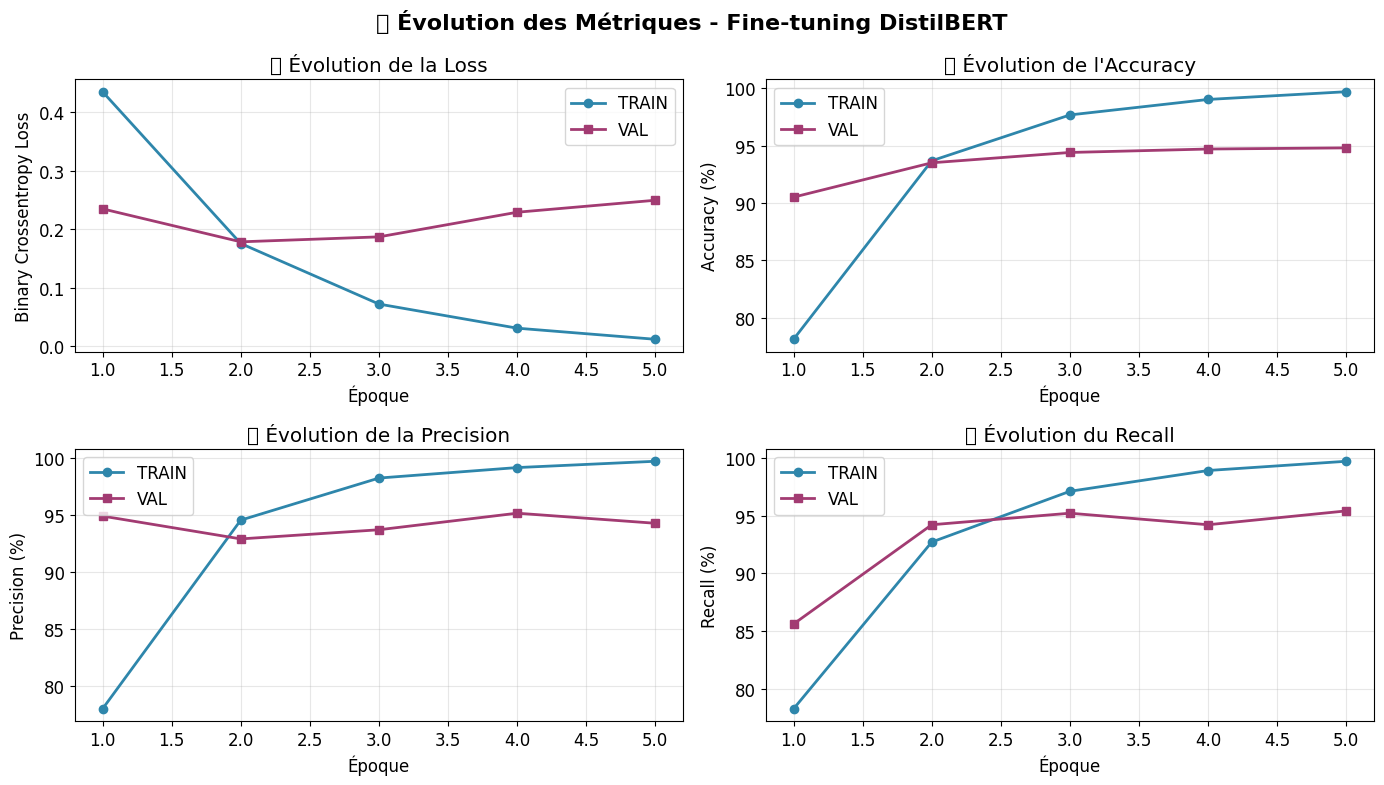

In [37]:
def plot_training_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']

    # Couleurs pour les graphiques
    colors = {'train': '#2E86AB', 'val': '#A23B72'}
    
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 8))
    plt.suptitle('📊 Évolution des Métriques - Fine-tuning DistilBERT', fontsize=16, fontweight='bold')

    plot_labels = [
        ('loss', '📉 Évolution de la Loss', 'Époque', 'Binary Crossentropy Loss'),
        ('accuracy', '📊 Évolution de l\'Accuracy', 'Époque', 'Accuracy (%)'),
        ('precision', '🎯 Évolution de la Precision', 'Époque', 'Precision (%)'),
        ('recall', '📊 Évolution du Recall', 'Époque', 'Recall (%)')
    ]

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)

        if i == 0:
            plt.plot(epochs_range, history.history[metric], color=colors['train'], marker='o', linewidth=2, label=f'TRAIN')
            plt.plot(epochs_range,history.history[f'val_{metric}'], color=colors['val'], marker='s', linewidth=2, label=f'VAL')
        else:
            plt.plot(epochs_range, [acc*100 for acc in history.history[metric]], color=colors['train'], marker='o', linewidth=2, label=f'TRAIN')
            plt.plot(epochs_range, [acc*100 for acc in history.history[f'val_{metric}']], color=colors['val'], marker='s', linewidth=2, label=f'VAL')
        plt.title(f'{plot_labels[i][1]}')
        plt.xlabel(plot_labels[i][2])
        plt.ylabel(plot_labels[i][3])
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_metrics(history)

### 📊 Analyse Détaillée des Résultats

Créons un tableau récapitulatif des performances :

In [38]:
# 📊 Analyse statistique détaillée
def analyser_performances_entrainement(history):
    """
    Analyse complète des performances d'entraînement
    """
    print("📊 ANALYSE DÉTAILLÉE DES PERFORMANCES\n")
    
    # Extraction des métriques
    metrics = {
        'Loss': {
            'train': history.history['loss'],
            'val': history.history['val_loss']
        },
        'Accuracy': {
            'train': history.history['accuracy'],
            'val': history.history['val_accuracy']
        },
        'Precision': {
            'train': history.history['precision'],
            'val': history.history['val_precision']
        },
        'Recall': {
            'train': history.history['recall'],
            'val': history.history['val_recall']
        }
    }
    
    # Création du tableau récapitulatif
    import pandas as pd
    
    results = []
    for metric_name, values in metrics.items():
        train_final = values['train'][-1]
        val_final = values['val'][-1]
        
        if metric_name == 'Loss':
            train_best = min(values['train'])
            val_best = min(values['val'])
            best_epoch = values['val'].index(val_best) + 1
        else:
            train_best = max(values['train'])
            val_best = max(values['val'])
            best_epoch = values['val'].index(val_best) + 1
        
        results.append({
            'Métrique': metric_name,
            'Train Final': f"{train_final:.4f}",
            'Val Final': f"{val_final:.4f}",
            'Meilleur Val': f"{val_best:.4f}",
            'Époque Opt.': best_epoch,
            'Gap Train-Val': f"{abs(train_final - val_final):.4f}"
        })
    
    df = pd.DataFrame(results)
    print("📋 Tableau récapitulatif:")
    print(df.to_string(index=False))
    
    # Analyse de convergence
    print(f"\n🔍 Analyse de convergence:")
    
    val_acc = metrics['Accuracy']['val']
    if len(val_acc) >= 3:
        last_3_epochs = val_acc[-3:]
        is_stable = max(last_3_epochs) - min(last_3_epochs) < 0.01
        
        if is_stable:
            print(f"   ✅ Convergence stable (variation < 1%)")
        else:
            print(f"   📈 Modèle encore en apprentissage")
    
    # Détection d'overfitting
    train_acc_final = metrics['Accuracy']['train'][-1]
    val_acc_final = metrics['Accuracy']['val'][-1]
    overfitting_gap = train_acc_final - val_acc_final
    
    print(f"\n🎯 Analyse de l'overfitting:")
    if overfitting_gap < 0.02:
        print(f"   ✅ Pas d'overfitting (gap: {overfitting_gap:.4f})")
    elif overfitting_gap < 0.05:
        print(f"   ⚠️ Overfitting léger (gap: {overfitting_gap:.4f})")
    else:
        print(f"   🚨 Overfitting significatif (gap: {overfitting_gap:.4f})")
    
    # F1-Score approximatif
    precision_final = metrics['Precision']['val'][-1]
    recall_final = metrics['Recall']['val'][-1]
    f1_score = 2 * (precision_final * recall_final) / (precision_final + recall_final)
    
    print(f"\n🏆 Score F1 estimé: {f1_score:.4f} ({f1_score*100:.2f}%)")
    
    # Recommandations
    print(f"\n💡 Recommandations:")
    if val_acc_final > 0.90:
        print(f"   🌟 Excellente performance ! Modèle prêt pour la production")
    elif val_acc_final > 0.85:
        print(f"   👍 Très bonne performance, peut être déployé")
    elif val_acc_final > 0.80:
        print(f"   ✅ Performance satisfaisante")
        if overfitting_gap > 0.05:
            print(f"   📝 Conseil: Augmenter la régularisation (dropout)")
    else:
        print(f"   ⚠️ Performance à améliorer")
        print(f"   📝 Conseils: Plus d'epochs, ajuster learning rate, ou plus de données")

# Lancer l'analyse
analyser_performances_entrainement(history)

📊 ANALYSE DÉTAILLÉE DES PERFORMANCES

📋 Tableau récapitulatif:
 Métrique Train Final Val Final Meilleur Val  Époque Opt. Gap Train-Val
     Loss      0.0117    0.2493       0.1782            2        0.2376
 Accuracy      0.9970    0.9480       0.9480            5        0.0490
Precision      0.9970    0.9427       0.9515            4        0.0543
   Recall      0.9970    0.9540       0.9540            5        0.0430

🔍 Analyse de convergence:
   ✅ Convergence stable (variation < 1%)

🎯 Analyse de l'overfitting:
   ⚠️ Overfitting léger (gap: 0.0490)

🏆 Score F1 estimé: 0.9483 (94.83%)

💡 Recommandations:
   🌟 Excellente performance ! Modèle prêt pour la production


## 🎯 Évaluation des Performances

Maintenant que notre modèle est entraîné, évaluons ses performances sur l'ensemble de test.

### 📊 Métriques d'Évaluation

Pour une classification binaire de sentiment, nous analyserons :

- **Accuracy** : Pourcentage de prédictions correctes
- **Precision** : Qualité des prédictions positives
- **Recall** : Capacité à détecter les vrais positifs
- **F1-Score** : Moyenne harmonique de precision et recall
- **Matrice de confusion** : Répartition détaillée des erreurs

In [39]:
# 🎯 Évaluation sur l'ensemble de test
print("🎯 ÉVALUATION SUR L'ENSEMBLE DE TEST\n")

# Chargement du meilleur modèle (sauvegardé par ModelCheckpoint)
print("📂 Chargement du meilleur modèle...")
try:
    best_model = tf.keras.models.load_model('best_distilbert_model.h5')
    print("✅ Meilleur modèle chargé depuis ModelCheckpoint")
except:
    best_model = model  # Utiliser le modèle actuel si pas de sauvegarde
    print("⚠️ Utilisation du modèle actuel (pas de checkpoint trouvé)")

# Évaluation complète
print(f"\n🔬 Évaluation en cours...")
test_results = best_model.evaluate(test_dataset, verbose=1)

# Récupération des métriques
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

# Calcul du F1-Score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n📊 RÉSULTATS SUR L'ENSEMBLE DE TEST:")
print(f"═" * 50)
print(f"🎯 Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"🎯 Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"🏆 F1-Score:  {f1_score:.4f} ({f1_score*100:.2f}%)")
print(f"📉 Loss:      {test_loss:.4f}")
print(f"═" * 50)

# Interprétation des résultats
print(f"\n💭 Interprétation:")
if test_accuracy > 0.90:
    print(f"   🌟 Excellente performance ! Modèle prêt pour la production")
elif test_accuracy > 0.85:
    print(f"   🎉 Très bonne performance ! Modèle fiable")
elif test_accuracy > 0.80:
    print(f"   ✅ Bonne performance, utilisable en pratique")
elif test_accuracy > 0.75:
    print(f"   👍 Performance correcte, peut être améliorée")
else:
    print(f"   ⚠️ Performance insuffisante, nécessite optimisation")

# Analyse équilibre Precision/Recall
balance = abs(test_precision - test_recall)
if balance < 0.05:
    print(f"   ⚖️ Bon équilibre Precision/Recall (diff: {balance:.3f})")
else:
    print(f"   ⚖️ Déséquilibre Precision/Recall (diff: {balance:.3f})")
    if test_precision > test_recall:
        print(f"      → Modèle conservateur (peu de faux positifs)")
    else:
        print(f"      → Modèle permissif (peu de faux négatifs)")

🎯 ÉVALUATION SUR L'ENSEMBLE DE TEST

📂 Chargement du meilleur modèle...
⚠️ Utilisation du modèle actuel (pas de checkpoint trouvé)

🔬 Évaluation en cours...
63/63 [==============================] - 32s 502ms/step - loss: 0.1782 - accuracy: 0.9350 - precision: 0.9290 - recall: 0.9420

📊 RÉSULTATS SUR L'ENSEMBLE DE TEST:
══════════════════════════════════════════════════
🎯 Accuracy:  0.9350 (93.50%)
🎯 Precision: 0.9290 (92.90%)
🎯 Recall:    0.9420 (94.20%)
🏆 F1-Score:  0.9355 (93.55%)
📉 Loss:      0.1782
══════════════════════════════════════════════════

💭 Interprétation:
   🌟 Excellente performance ! Modèle prêt pour la production
   ⚖️ Bon équilibre Precision/Recall (diff: 0.013)


### 🔍 Matrice de Confusion

Analysons en détail les types d'erreurs commises par notre modèle :

In [40]:
# 🔍 Génération des prédictions pour la matrice de confusion
print("🔍 Génération des prédictions pour analyse détaillée...\n")

# Récupération des vraies étiquettes et prédictions
y_true = []
y_pred = []
y_pred_proba = []

print("📊 Collecte des prédictions...")
for batch_features, batch_labels in test_dataset:
    # Prédictions
    predictions = best_model([
        batch_features['input_ids'],
        batch_features['attention_mask']
    ], training=False)
    
    # Conversion en listes
    y_true.extend(batch_labels.numpy())
    y_pred_proba.extend(predictions.numpy().flatten())
    y_pred.extend((predictions.numpy() > 0.5).astype(int).flatten())

print(f"✅ {len(y_true)} prédictions collectées")

# Conversion en arrays numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

print(f"📊 Distribution des vraies étiquettes:")
print(f"   Négatives (0): {np.sum(y_true == 0)} ({np.sum(y_true == 0)/len(y_true)*100:.1f}%)")
print(f"   Positives (1): {np.sum(y_true == 1)} ({np.sum(y_true == 1)/len(y_true)*100:.1f}%)")

print(f"\n🎯 Distribution des prédictions:")
print(f"   Négatives (0): {np.sum(y_pred == 0)} ({np.sum(y_pred == 0)/len(y_pred)*100:.1f}%)")
print(f"   Positives (1): {np.sum(y_pred == 1)} ({np.sum(y_pred == 1)/len(y_pred)*100:.1f}%)")

🔍 Génération des prédictions pour analyse détaillée...

📊 Collecte des prédictions...
✅ 1000 prédictions collectées
📊 Distribution des vraies étiquettes:
   Négatives (0): 500 (50.0%)
   Positives (1): 500 (50.0%)

🎯 Distribution des prédictions:
   Négatives (0): 493 (49.3%)
   Positives (1): 507 (50.7%)


📈 Création de la matrice de confusion...



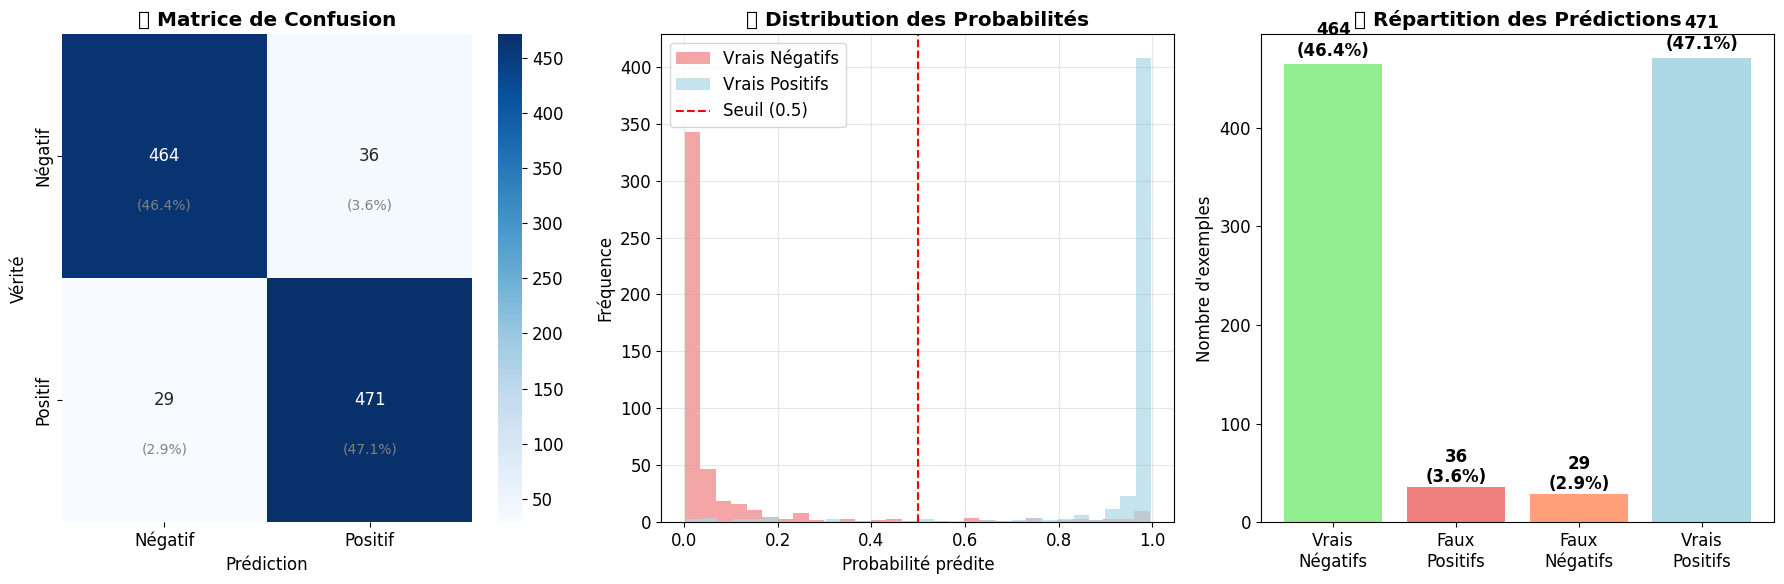

📋 Analyse détaillée de la matrice:
   ✅ Vrais Négatifs (TN):   464 (46.4%)
   ❌ Faux Positifs (FP):     36 (3.6%) - Erreur Type I
   ❌ Faux Négatifs (FN):     29 (2.9%) - Erreur Type II
   ✅ Vrais Positifs (TP):   471 (47.1%)

🎯 Interprétation des erreurs:
   📊 Plus de Faux Positifs: Le modèle tend à sur-classifier comme positif
   💡 Conseil: Augmenter le seuil de décision (> 0.5)


In [41]:
# 📈 Création de la matrice de confusion et visualisations
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def visualiser_matrice_confusion(y_true, y_pred, y_pred_proba):
    """
    Crée une visualisation complète de la matrice de confusion
    """
    print("📈 Création de la matrice de confusion...\n")
    
    # Calcul de la matrice
    cm = confusion_matrix(y_true, y_pred)
    
    # Configuration de la figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Matrice de confusion
    ax1 = axes[0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Négatif', 'Positif'],
                yticklabels=['Négatif', 'Positif'], ax=ax1)
    ax1.set_title('🔍 Matrice de Confusion', fontweight='bold')
    ax1.set_xlabel('Prédiction')
    ax1.set_ylabel('Vérité')
    
    # Ajout des pourcentages
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / total * 100
            ax1.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    # 2. Distribution des probabilités prédites
    ax2 = axes[1]
    
    # Séparer par classe réelle
    neg_probs = y_pred_proba[y_true == 0]
    pos_probs = y_pred_proba[y_true == 1]
    
    ax2.hist(neg_probs, bins=30, alpha=0.7, label='Vrais Négatifs', color='lightcoral')
    ax2.hist(pos_probs, bins=30, alpha=0.7, label='Vrais Positifs', color='lightblue')
    ax2.axvline(x=0.5, color='red', linestyle='--', label='Seuil (0.5)')
    
    ax2.set_title('📊 Distribution des Probabilités', fontweight='bold')
    ax2.set_xlabel('Probabilité prédite')
    ax2.set_ylabel('Fréquence')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Analyse des erreurs
    ax3 = axes[2]
    
    # Types d'erreurs
    tn, fp, fn, tp = cm.ravel()
    
    categories = ['Vrais\nNégatifs', 'Faux\nPositifs', 'Faux\nNégatifs', 'Vrais\nPositifs']
    values = [tn, fp, fn, tp]
    colors = ['lightgreen', 'lightcoral', 'lightsalmon', 'lightblue']
    
    bars = ax3.bar(categories, values, color=colors)
    ax3.set_title('📊 Répartition des Prédictions', fontweight='bold')
    ax3.set_ylabel('Nombre d\'exemples')
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value}\n({value/total*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Analyse textuelle
    print(f"📋 Analyse détaillée de la matrice:")
    print(f"   ✅ Vrais Négatifs (TN):  {tn:4d} ({tn/total*100:.1f}%)")
    print(f"   ❌ Faux Positifs (FP):   {fp:4d} ({fp/total*100:.1f}%) - Erreur Type I")
    print(f"   ❌ Faux Négatifs (FN):   {fn:4d} ({fn/total*100:.1f}%) - Erreur Type II")
    print(f"   ✅ Vrais Positifs (TP):  {tp:4d} ({tp/total*100:.1f}%)")
    
    print(f"\n🎯 Interprétation des erreurs:")
    if fp > fn:
        print(f"   📊 Plus de Faux Positifs: Le modèle tend à sur-classifier comme positif")
        print(f"   💡 Conseil: Augmenter le seuil de décision (> 0.5)")
    elif fn > fp:
        print(f"   📊 Plus de Faux Négatifs: Le modèle tend à sous-classifier comme positif")
        print(f"   💡 Conseil: Diminuer le seuil de décision (< 0.5)")
    else:
        print(f"   ⚖️ Erreurs équilibrées: Bon seuil de décision")

# Génération des visualisations
visualiser_matrice_confusion(y_true, y_pred, y_pred_proba)

### 📝 Rapport de Classification

Générons un rapport détaillé avec toutes les métriques :

In [ ]:
# 📝 Rapport de classification détaillé
print("📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ\n")

# Rapport scikit-learn
class_report = classification_report(y_true, y_pred, 
                                   target_names=['Négatif', 'Positif'],
                                   output_dict=True)

print("📊 Métriques par classe:")
print("═" * 70)
print(f"{'Classe':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("═" * 70)

for class_name in ['Négatif', 'Positif']:
    metrics = class_report[class_name]
    print(f"{class_name:<10} {metrics['precision']:<10.4f} {metrics['recall']:<10.4f} "
          f"{metrics['f1-score']:<10.4f} {int(metrics['support']):<10}")

print("═" * 70)
print(f"{'Macro Avg':<10} {class_report['macro avg']['precision']:<10.4f} "
      f"{class_report['macro avg']['recall']:<10.4f} "
      f"{class_report['macro avg']['f1-score']:<10.4f} "
      f"{int(class_report['macro avg']['support']):<10}")
print(f"{'Weighted Avg':<10} {class_report['weighted avg']['precision']:<10.4f} "
      f"{class_report['weighted avg']['recall']:<10.4f} "
      f"{class_report['weighted avg']['f1-score']:<10.4f} "
      f"{int(class_report['weighted avg']['support']):<10}")

# Analyse de la qualité globale
overall_f1 = class_report['weighted avg']['f1-score']
print(f"\n🏆 Score F1 Global: {overall_f1:.4f} ({overall_f1*100:.2f}%)")

print(f"\n💭 Évaluation de la qualité:")
if overall_f1 > 0.90:
    print(f"   🌟 Qualité exceptionnelle - Modèle de production")
elif overall_f1 > 0.85:
    print(f"   🎉 Excellente qualité - Prêt pour déploiement")
elif overall_f1 > 0.80:
    print(f"   ✅ Bonne qualité - Utilisable en pratique")
elif overall_f1 > 0.75:
    print(f"   👍 Qualité correcte - Améliorations possibles")
else:
    print(f"   ⚠️ Qualité insuffisante - Optimisation nécessaire")

# Comparaison avec un baseline
baseline_accuracy = max(np.sum(y_true == 0), np.sum(y_true == 1)) / len(y_true)
improvement = test_accuracy - baseline_accuracy

print(f"\n📊 Comparaison avec baseline:")
print(f"   🎯 Accuracy modèle: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   📊 Baseline (classe majoritaire): {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
print(f"   📈 Amélioration: +{improvement:.4f} (+{improvement*100:.2f} points)")

if improvement > 0.20:
    print(f"   🚀 Amélioration exceptionnelle !")
elif improvement > 0.10:
    print(f"   🎉 Excellente amélioration !")
elif improvement > 0.05:
    print(f"   ✅ Bonne amélioration")
else:
    print(f"   ⚠️ Amélioration modeste")

📝 RAPPORT DE CLASSIFICATION DÉTAILLÉ

📊 Métriques par classe:
══════════════════════════════════════════════════════════════════════
Classe     Precision  Recall     F1-Score   Support   
══════════════════════════════════════════════════════════════════════
Négatif    0.9412     0.9280     0.9345     500       
Positif    0.9290     0.9420     0.9355     500       
══════════════════════════════════════════════════════════════════════
Macro Avg  0.9351     0.9350     0.9350     1000      
Weighted Avg 0.9351     0.9350     0.9350     1000      

🏆 Score F1 Global: 0.9350 (93.50%)

💭 Évaluation de la qualité:
   🌟 Qualité exceptionnelle - Modèle de production

📊 Comparaison avec baseline:
   🎯 Accuracy modèle: 0.9350 (93.50%)
   📊 Baseline (classe majoritaire): 0.5000 (50.00%)
   📈 Amélioration: +0.4350 (+43.50 points)
   🚀 Amélioration exceptionnelle !

💡 Le modèle DistilBERT apporte une valeur significative par rapport à une approche naïve !


## 🔮 Fonction de Prédiction Interactive

Créons une fonction pratique pour tester notre modèle sur de nouvelles phrases !

In [ ]:
# 🔮 Fonction de prédiction de sentiment
def predire_sentiment(texte, modele=None, tokenizer=tokenizer, max_length=MAX_LENGTH, verbose=True):
    """
    Prédit le sentiment d'un texte donné
    
    Args:
        texte (str): Texte à analyser
        modele: Modèle à utiliser (par défaut le meilleur modèle)
        tokenizer: Tokenizer DistilBERT
        max_length (int): Longueur maximale de séquence
        verbose (bool): Affichage détaillé
    
    Returns:
        dict: Résultats de prédiction
    """
    # Utiliser le meilleur modèle par défaut
    if modele is None:
        try:
            modele = tf.keras.models.load_model('best_distilbert_model.h5')
        except:
            print("❌ Erreur lors du chargement du modèle. Utilisation du modèle actuel.")
            modele = best_model  # Fallback sur le modèle actuel
    
    if verbose:
        print(f"🔮 Analyse du sentiment pour: \"{texte}\"\n")
    
    # Tokenisation du texte
    tokens = tokenizer(
        texte,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
    if verbose:
        print(f"📝 Tokenisation:")
        decoded_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
        # Afficher seulement les tokens non-padding
        real_tokens = [tok for tok in decoded_tokens if tok != '[PAD]'][:20]  # Limiter l'affichage
        print(f"   🔤 Tokens: {' '.join(real_tokens)}{'...' if len(real_tokens) == 20 else ''}")
        print(f"   📏 Longueur: {len([tok for tok in decoded_tokens if tok != '[PAD]'])} tokens")
    
    # Prédiction
    prediction = modele([
        tokens['input_ids'],
        tokens['attention_mask']
    ], training=False)
    
    # Extraction des résultats
    probabilite = float(prediction[0][0])
    sentiment = "Positif" if probabilite > 0.5 else "Négatif"
    confiance = max(probabilite, 1 - probabilite)
    
    if verbose:
        print(f"\n🎯 Résultats:")
        print(f"   📊 Sentiment: {sentiment}")
        print(f"   📈 Probabilité: {probabilite:.4f}")
        print(f"   🎯 Confiance: {confiance:.4f} ({confiance*100:.1f}%)")
        
        # Interprétation de la confiance
        if confiance > 0.9:
            print(f"   💪 Très haute confiance - Prédiction très fiable")
        elif confiance > 0.8:
            print(f"   ✅ Haute confiance - Prédiction fiable")
        elif confiance > 0.7:
            print(f"   👍 Confiance modérée - Prédiction raisonnable")
        elif confiance > 0.6:
            print(f"   ⚠️ Faible confiance - Prédiction incertaine")
        else:
            print(f"   🤔 Très faible confiance - Texte ambigu")
    
    return {
        'texte': texte,
        'sentiment': sentiment,
        'probabilite': probabilite,
        'confiance': confiance,
        'tokens': len([tok for tok in tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]) if tok != '[PAD]'])
    }

print("✅ Fonction de prédiction créée !")
print("🎯 Utilisez: predire_sentiment('Votre texte ici')")

✅ Fonction de prédiction créée !
🎯 Utilisez: predire_sentiment('Votre texte ici')


### 🧪 Tests sur des Exemples Variés

Testons notre modèle sur différents types de textes :

In [ ]:
# 🧪 Tests sur des exemples variés
exemples_tests = [
    # Exemples clairement positifs
    "Huge respect for the work you're doing @user 🙌 The future of crypto is in good hands! 🔥 #Web3 #Bullish",
    "$SOL is on fire again! 🔥 Loving the momentum — let's ride this wave 🌊🚀 #CryptoSeason #SOL",
    "This kind of innovation is exactly why I stay in this space 💡 Hats off to @user! #DeFi #CryptoWins 🎉",
    
    # Exemples clairement négatifs
    "Seriously @user? Another rug pull? 😡 This space needs real builders, not scammers. #CryptoScam 🚨",
    "Watching $XYZ tank again… feels like 2025 all over 😓 Can we please get some real use cases? #CryptoCrash 📉",
    "Tired of the hype with zero delivery. @user’s project promised the moon and gave us dust 🌪️ #Disappointed",
    
    # Exemples neutres/ambigus
    "Interesting move by @user — not sure what it means long-term 🤔 Time will tell. #CryptoNews",
    "Another token launch… Will it be the next $PEPE or just fade away? 🤷‍♂️ Good luck, @user. #NewToken",
    "$BTC holding steady — no breakout, no breakdown. Just… sideways. @user any thoughts? 😶",
    
    # Exemples avec sarcasme/ironie
    "Oh wow, another “revolutionary” layer 1 chain from @user... because we clearly needed one more. 😅 #SoInnovative",
    "Great job @user, you managed to launch the 4,328th meme coin today 🥳 Truly groundbreaking stuff. #Web3Genius",
    "Can’t wait to lose more money on another “can’t miss” token 👏 Thanks for the alpha @user 😂 #CryptoLife",
]

print("🧪 TESTS SUR EXEMPLES VARIÉS\n")
print("═" * 80)

resultats_tests = []

for i, exemple in enumerate(exemples_tests, 1):
    print(f"\n📝 Test {i}/{len(exemples_tests)}:")
    print("─" * 60)
    
    resultat = predire_sentiment(exemple, verbose=True)
    resultats_tests.append(resultat)
    
    print("─" * 60)

print(f"\n✅ Tests terminés sur {len(exemples_tests)} exemples !")

🧪 TESTS SUR EXEMPLES VARIÉS

════════════════════════════════════════════════════════════════════════════════

📝 Test 1/13:
────────────────────────────────────────────────────────────
🔮 Analyse du sentiment pour: "Huge respect for the work you're doing @user 🙌 The future of crypto is in good hands! 🔥 #Web3 #Bullish"

📝 Tokenisation:
   🔤 Tokens: [CLS] huge respect for the work you ' re doing @ user [UNK] the future of crypt ##o is in...
   📏 Longueur: 31 tokens

🎯 Résultats:
   📊 Sentiment: Positif
   📈 Probabilité: 0.9944
   🎯 Confiance: 0.9944 (99.4%)
   💪 Très haute confiance - Prédiction très fiable
────────────────────────────────────────────────────────────

📝 Test 2/13:
────────────────────────────────────────────────────────────
🔮 Analyse du sentiment pour: "$SOL is on fire again! 🔥 Loving the momentum — let's ride this wave 🌊🚀 #CryptoSeason #SOL"

📝 Tokenisation:
   🔤 Tokens: [CLS] $ sol is on fire again ! [UNK] loving the momentum — let ' s ride this wave [UNK]...
   📏 Longu